# Определение возраста покупателей

Сетевой магазин внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Требуется построить модель, которая по фотографии определит приблизительный возраст человека.

Исходные данные: набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
data = pd.read_csv('/datasets/faces/labels.csv')
print(data.info())
print(data.head())
display(data.sample(10))
display(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None
    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17


,file_name,real_age
4456,004456.jpg,17
3324,003324.jpg,24
6131,006134.jpg,15
6312,006316.jpg,76
2718,002718.jpg,26
293,000293.jpg,45
1700,001700.jpg,42
3548,003548.jpg,39
1193,001193.jpg,71
1952,001952.jpg,80


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


file_name    363
real_age     363
dtype: int64
file_name    1
real_age     1
dtype: int64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3b4a70a8d0>]],
      dtype=object)

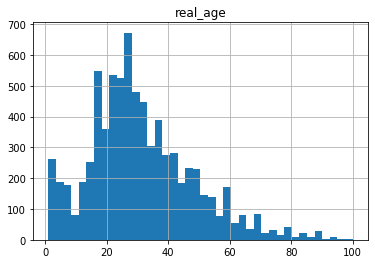

In [3]:
print(data[data['real_age'] < 5].count())
print(data[data['real_age'] > 99].count())

data.hist(bins=40)

Found 7591 images belonging to 1 classes.


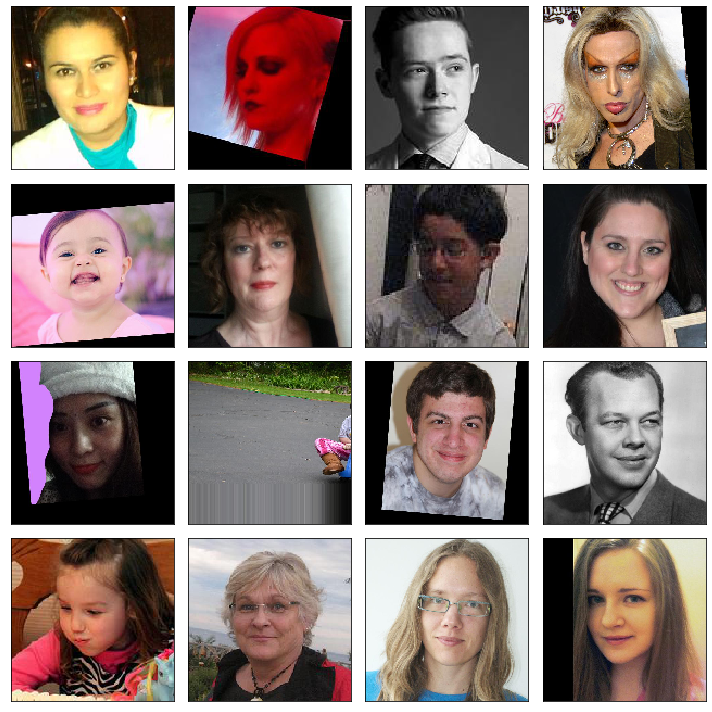

In [6]:
datagen = ImageDataGenerator(rescale=1/255.)

train_datagen_flow = datagen.flow_from_directory(
    '/datasets/faces/',
    target_size=(150, 150),
    batch_size=16,
    class_mode='sparse')

features = next(train_datagen_flow)

fig = plt.figure(figsize=(10,10))

for i in range(16):
    fig.add_subplot(4, 4, i+1)
    image = features[0]
    image = image[i]
    array = np.array(image)
    plt.imshow(array)
# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
# gen_flow[1])
# print(image)
image = Image.open('/datasets/faces/final_files/003966.jpg')
array = np.array(image)
plt.imshow(array)

Распределение по возрастам в датасете неравномерное, половина людей на фотографиях возрастом от 20 до 40 лет, при этом есть большое колличество фотографий людей с возрастом  меньше 5 лет (363 фото). 75 перцентиль имеет значение возраста - 41 год, а максимальный возрас 100 лет. Фотографии в датасете имеют различные повороты, цветовую гамму (цветные и ч/б), а также размер. Некоторые фото имеют дефекты в виде смазаной границы или следы обработки в редакторе.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
import numpy as np
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.metrics import MeanAbsoluteError, mse


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.25, 
                                 horizontal_flip=True)

    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                     directory = path +'final_files/',
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224),
                                                     batch_size=16,
                                                     class_mode='raw',
                                                     validation_split = 0.25,
                                                     subset='training',
                                                     seed=12345)
    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(rescale=1./255,  validation_split=0.25) 
    
    val_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
                                                        directory = path +'final_files/',
                                                        x_col='file_name',
                                                        y_col='real_age',
                                                        target_size=(224, 224),
                                                        batch_size=16,
                                                        class_mode='raw',
                                                        validation_split = 0.25,
                                                        subset='validation',
                                                        seed=12345)

    
    return val_datagen_flow

# def load_test(path):
#     features_train = np.load(path + 'test_features.npy')
#     target_train = np.load(path + 'test_target.npy')
#     features_train = features_train.reshape(features_train.shape[0], 28 * 28) / 255.
#     return (features_train, target_train)
    


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
    weights='imagenet',
    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=8,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, epochs=epochs, shuffle=True)
 
    return model

```

```

2021-11-14 18:21:23.819955: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2021-11-14 18:21:23.821692: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2021-11-14 18:21:24.704371: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-11-14 18:21:25.407716: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-11-14 18:21:25.407805: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-11-14 18:21:25.407838: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-11-14 18:21:25.409635: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-11-14 18:21:25.410131: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-11-14 18:21:25.412912: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2021-11-14 18:21:25.414525: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2021-11-14 18:21:25.414615: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-11-14 18:21:25.419259: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2021-11-14 18:21:25.419694: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2021-11-14 18:21:25.426970: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2021-11-14 18:21:25.427823: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4284e90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-11-14 18:21:25.427858: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-11-14 18:21:25.581647: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x430aeb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-11-14 18:21:25.581693: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2021-11-14 18:21:25.584467: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-11-14 18:21:25.584549: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-11-14 18:21:25.584564: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-11-14 18:21:25.584603: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-11-14 18:21:25.584617: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-11-14 18:21:25.584631: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2021-11-14 18:21:25.584644: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2021-11-14 18:21:25.584655: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-11-14 18:21:25.589729: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2021-11-14 18:21:25.589819: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-11-14 18:21:25.915688: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-11-14 18:21:25.915742: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2021-11-14 18:21:25.915750: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2021-11-14 18:21:25.920483: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/8
2021-11-14 18:21:37.227704: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-11-14 18:21:37.527723: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 49s - loss: 197.0088 - mae: 10.2431 - val_loss: 397.0827 - val_mae: 14.7516
Epoch 2/8
356/356 - 41s - loss: 83.4028 - mae: 6.9667 - val_loss: 118.1263 - val_mae: 8.3979
Epoch 3/8
356/356 - 41s - loss: 57.9429 - mae: 5.7834 - val_loss: 103.8209 - val_mae: 7.4412
Epoch 4/8
356/356 - 40s - loss: 41.1330 - mae: 4.8703 - val_loss: 82.9269 - val_mae: 6.8152
Epoch 5/8
356/356 - 41s - loss: 31.2806 - mae: 4.2805 - val_loss: 71.3014 - val_mae: 6.3379
Epoch 6/8
356/356 - 41s - loss: 25.5266 - mae: 3.8728 - val_loss: 71.0454 - val_mae: 6.3470
Epoch 7/8
356/356 - 40s - loss: 19.8098 - mae: 3.3974 - val_loss: 78.2565 - val_mae: 6.5404
Epoch 8/8
356/356 - 40s - loss: 15.7789 - mae: 3.0510 - val_loss: 78.9327 - val_mae: 6.8643
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 78.9327 - mae: 6.8643
Test MAE: 6.8643

```

## Анализ обученной модели

В модели использовалась функция уменьшения средней квадратичной ошибки для минимизации средней абсолютной ошибки, показатель MAE составил 6.8643, это означает, что модель в среднем ошибается на 6.8 лет. Для достижения данной величины MAE колличество эпох было равно 8 и скорость обучения составила 0.0001. Алгоритм обучения использовался Adam. Полученная модель позволяет определить возрастную группу человека, для дальнейшего анализа покупок, а также позволяет выявить незаконную продажу алкоголя и сигарет малолетним детям, при этом для детей возрастов 11-17 лет модель может давать некорректные сигналы.